# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [32]:
# Используемые функции
# функция по обработке выбросов по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, round(lower_bound),round(upper_bound)

def get_age_category(age):
    if age < 30:
        age_category = '<30'
    elif 30 <= age < 40:
        age_category = '30-40'
    elif 40 <= age < 50:
        age_category = '40-50'
    elif 50 <= age < 60:
        age_category = '50-60'
    else:
        age_category = '60+'
    return age_category

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [4]:
uniq_dict = {}
for col in df.columns.tolist():
    unique_values_num =len(df[col].unique().tolist())
    uniq_dict.update({col:unique_values_num})

uniq_dict

{'age': 76,
 'job': 12,
 'marital': 3,
 'education': 4,
 'default': 2,
 'balance': 3803,
 'housing': 2,
 'loan': 2,
 'contact': 3,
 'day': 31,
 'month': 12,
 'duration': 1428,
 'campaign': 36,
 'pdays': 472,
 'previous': 34,
 'poutcome': 4,
 'deposit': 2}

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.unique().tolist()

['admin.',
 'technician',
 'services',
 'management',
 'retired',
 'blue-collar',
 'unemployed',
 'entrepreneur',
 'housemaid',
 'unknown',
 'self-employed',
 'student']

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df_copy = df.copy()
df_copy['balance'] = df_copy['balance'].apply(lambda x: str(x).replace(',','.').replace('$','').replace(' ',''))
df_copy['balance'] = df_copy['balance'].astype('float')
df_copy['balance'].mean().round(3)

1529.129

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

values = {
    'balance': df_copy['balance'].median()
}
#заполняем пропуски в соответствии с заявленным словарем
df_copy = df_copy.fillna(values)
df_copy['balance'].mean().round(3)

1526.936

### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df_copy['job'].mode()

df_copy['job'] = np.where(df_copy['job']=='unknown', df_copy['job'].mode(),df_copy['job'])

In [9]:
mask1 = df_copy['education']=="secondary"
mask2 = df_copy['job']=="management"

df_copy[mask1 & mask2]['balance'].mean().round(3)

1370.304

### Задание 6

In [14]:
# удалите все выбросы для признака balance
# ваш код
outliers, cleaned,lower_bound,upper_bound = outliers_iqr(df_copy, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {lower_bound}')
print(f'Нижняя граница: {upper_bound}')



Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница: -2241
Нижняя граница: 4063


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

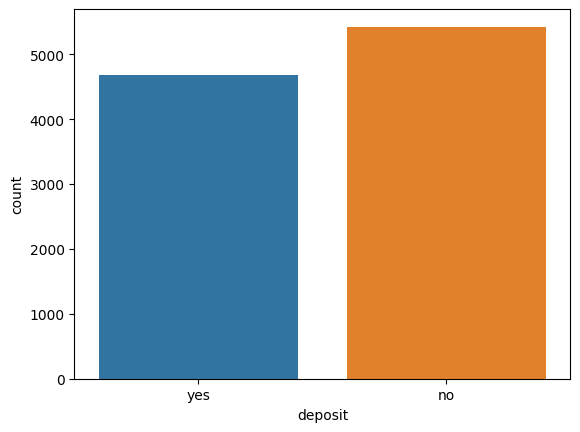

In [19]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(cleaned.deposit.value_counts())
sns.countplot(data=cleaned, x="deposit", hue='deposit');

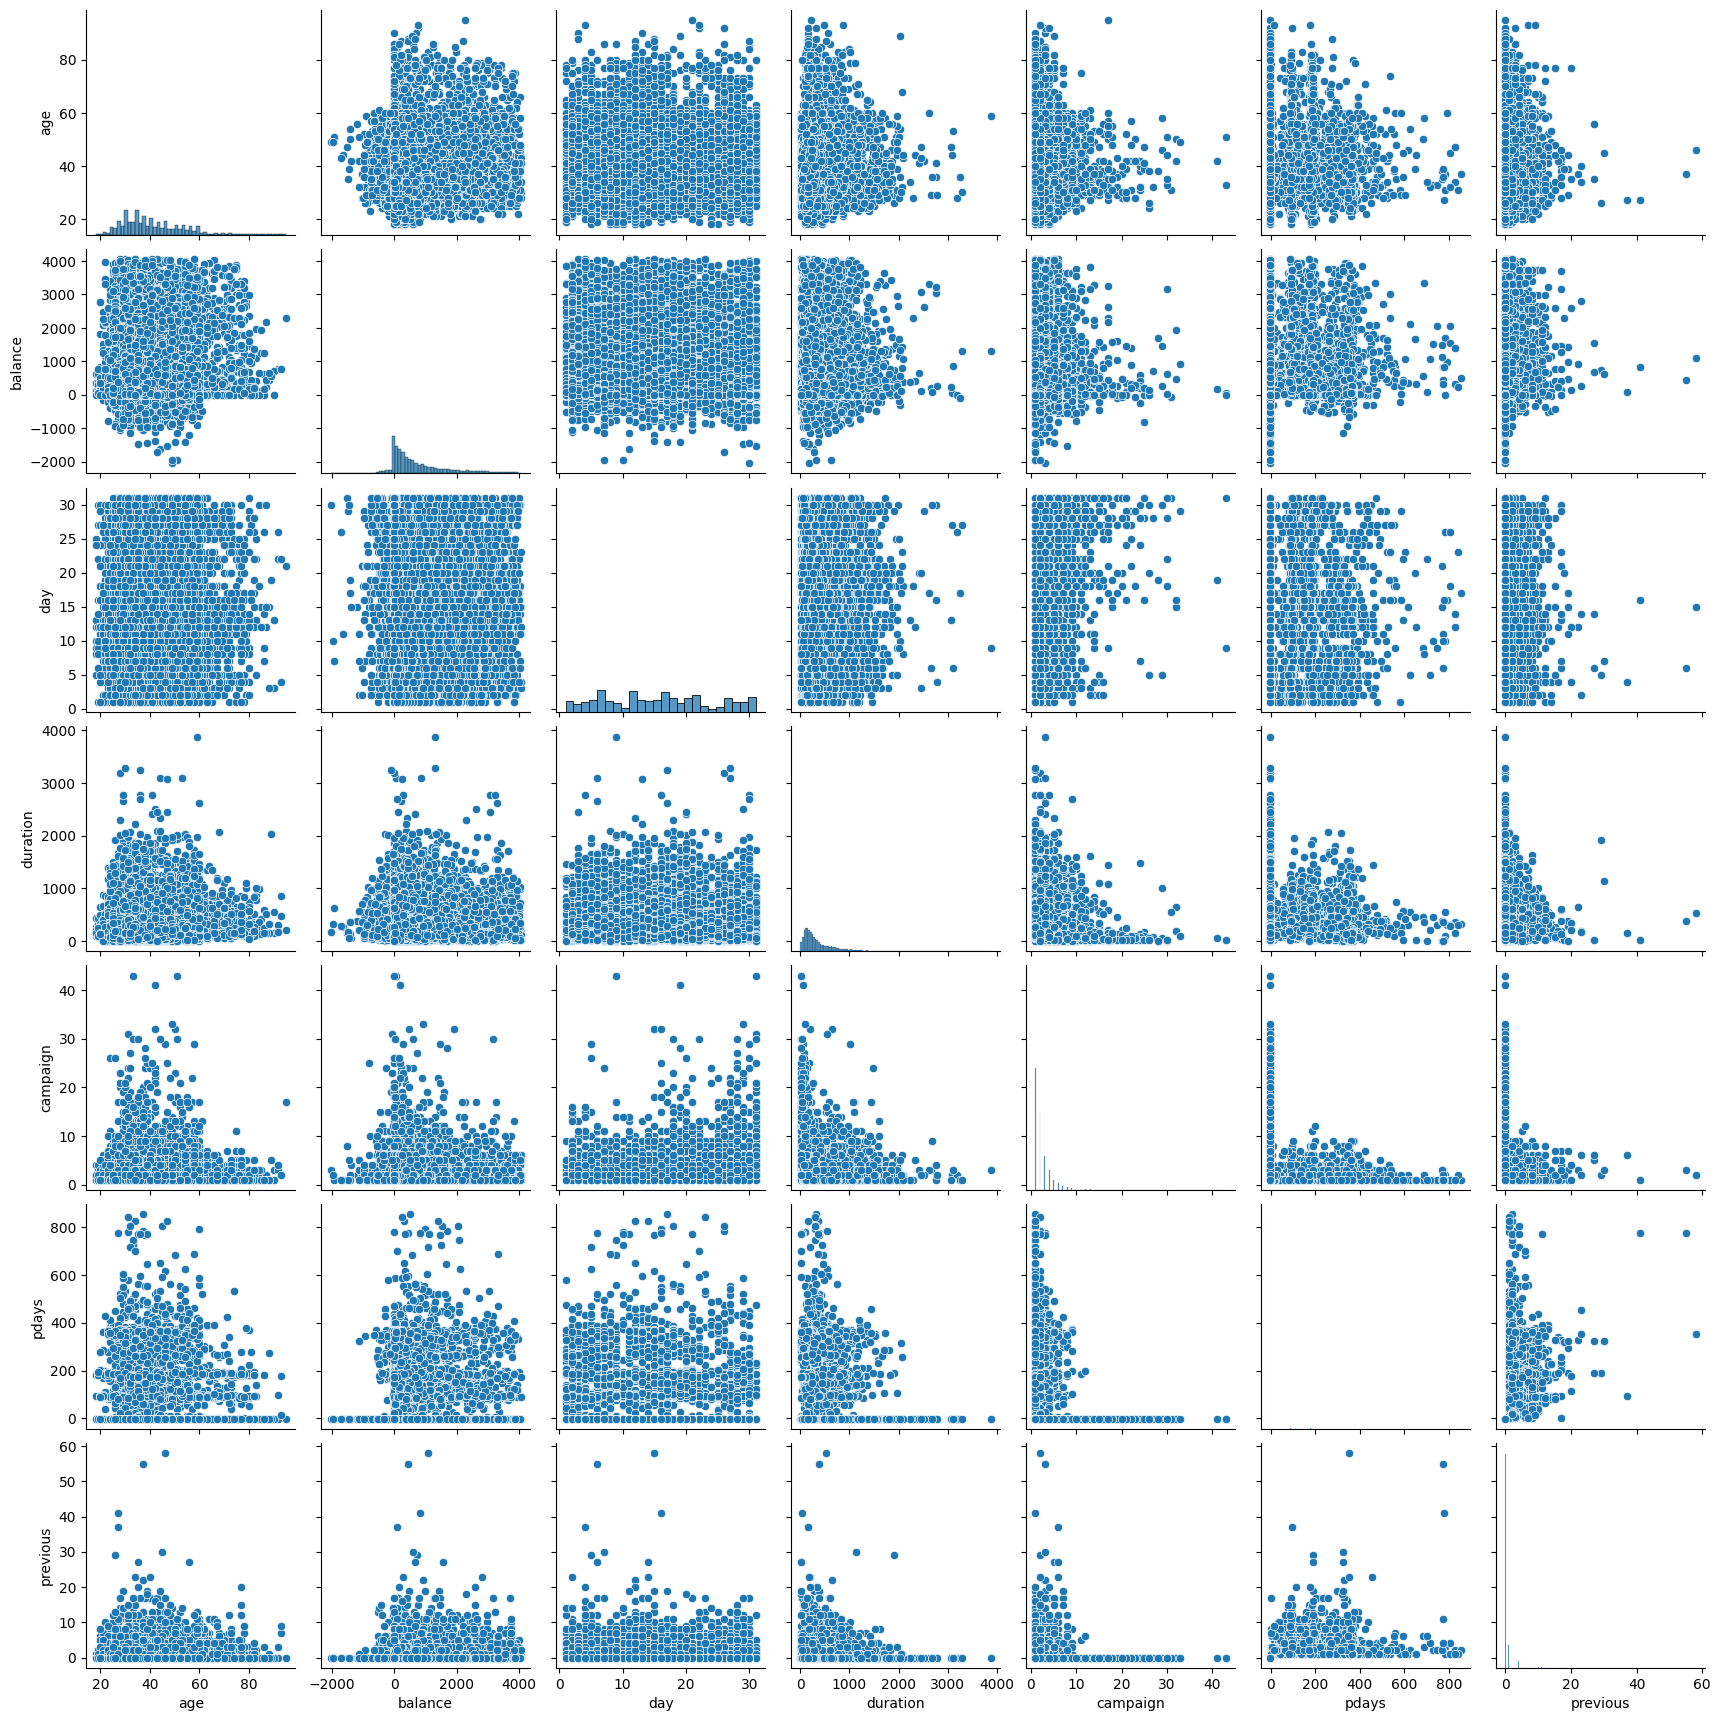

In [21]:
sns.pairplot(data=cleaned)

### Задания 2 и 3

In [20]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5078,9939,5243,8712,7283,2617,7570,5424


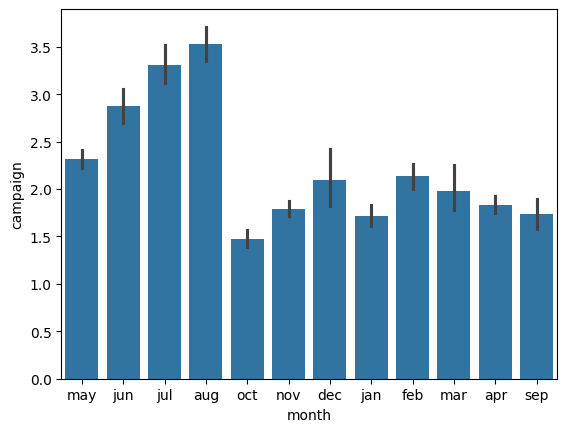

In [24]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
display(cleaned.describe(include= 'object'))
sns.barplot(data=cleaned, x='month', y='campaign');

In [28]:
cleaned.poutcome.value_counts()

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

### Задание 6

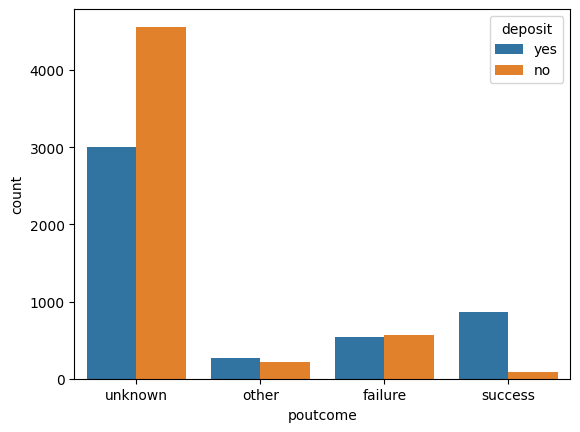

In [31]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
sns.countplot(data=cleaned, x='poutcome', hue='deposit');

### Задание 7

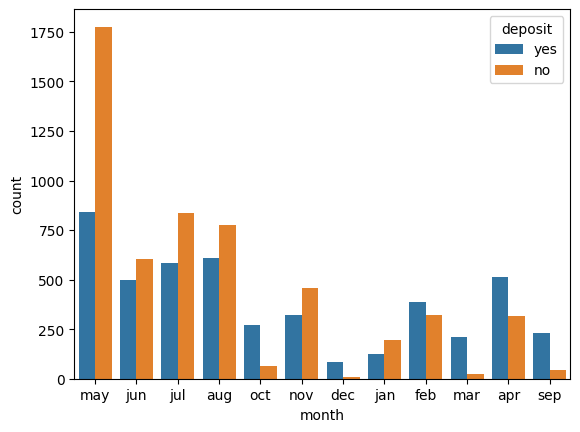

In [30]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
sns.countplot(data=cleaned, x='month', hue='deposit');

### Задание 8

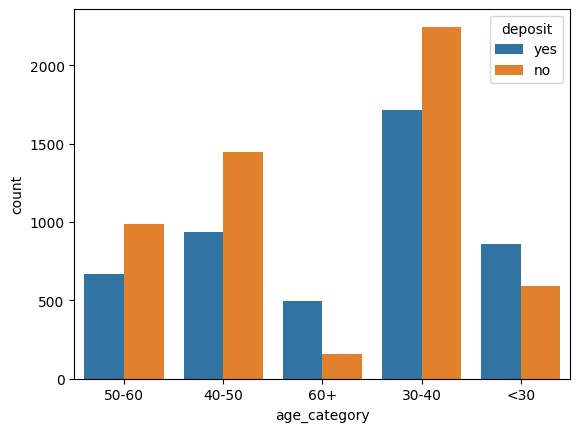

In [35]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_category'] = cleaned['age'].apply(get_age_category)

sns.countplot(data=cleaned, x='age_category', hue='deposit');

### Задания 9 и 10

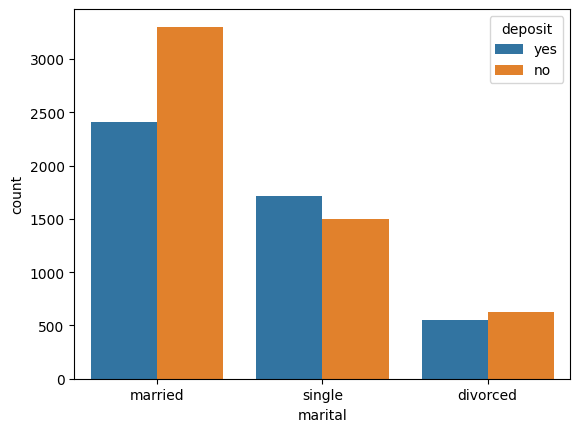

In [38]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(data=cleaned, x='marital', hue='deposit');

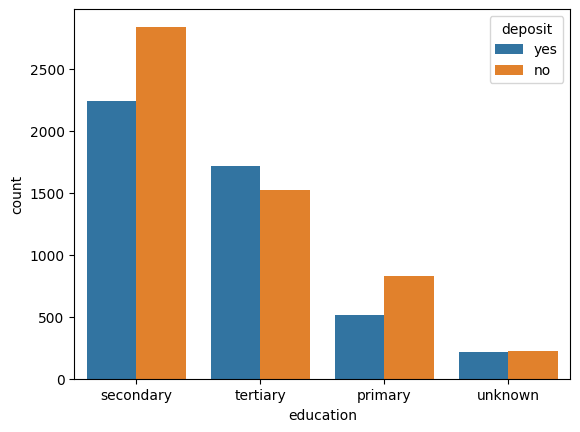

In [39]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(data=cleaned, x='education', hue='deposit');

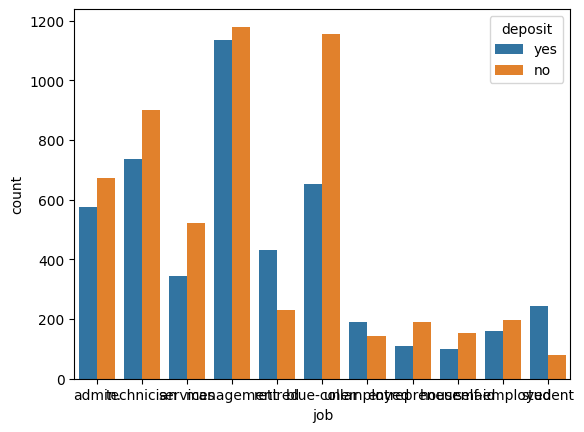

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(data=cleaned, x='job', hue='deposit'size);

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [3]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna